In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import arviz

from data_handling.api import direct_download

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
#tickers = ['SPY', 'EFA', 'EEM', 'LQD', 'TIP', 'VNQ', 'IEF', 'BWX']
tickers = ['SPY', 'MSFT', 'TSLA']
data = await direct_download(tickers)

In [3]:
log_returns = np.log(data['adj_close'].unstack()).diff().dropna()
#log_returns = log_returns['SPY']

In [33]:
# Univariate ~ 45 seconds
model_spec = '''
data {
    int len;
    vector[len] returns;
}
parameters {
    real mu;
    real<lower=-1, upper=1> phi;
    real<lower=0> sigma;
    vector[len] h_std;
}
transformed parameters {
    vector[len] h = h_std * sigma;          // Now normal(0, sigma)
    h[1] /= sqrt(1 - phi^2);                // Scale h[1]
    h += mu;                                // Now normal(mu, sigma)
    h[2:len] += phi * (h[1:(len-1)] - mu);  // Apply autoregressive
}
model {
    h_std ~ std_normal();
    returns ~ normal(0, exp(h/2));
}
generated quantities {
    vector[21] forecast;             // Generate 21 days ahead forecast using each posterior parameter draw
    real h_curr;
    real h_prev = h[len];
    for (t in 1:21) {
        h_curr = mu + phi * (h_prev - mu) + normal_rng(0, sigma);
        forecast[t] = normal_rng(0, exp(h_curr / 2));
        h_prev = h_curr;
    }
}
'''

In [4]:
# Constant Correlation Multivariate
# v2 ~ 10 minutes
model_spec = '''
data {
    int len;                  // Length of time series
    int num;                  // Number of tickers
    vector[num] returns[len];
    corr_matrix[num] corr;    // Correlation matrix
}
transformed data {
    cholesky_factor_corr[num] L;
    L = cholesky_decompose(corr);
}
parameters {
    vector[num] mu;
    vector<lower=-1, upper=1>[num] phi;
    vector<lower=0>[num] sigma;
    vector[num] h_std[len];
}
transformed parameters {
    vector[num] h[len];        // Distributed normal(mu + phi * (h[t-1] - mu), sigma)
    for (t in 1:len) {
        if (t == 1) {
            h[t] = h_std[t] .* sigma;
            h[t] += mu;
        }
        else {
            h[t] = h_std[t] .* sigma;
            h[t] += mu + phi .* (h[t-1] - mu);
        }
    }
}
model {
    mu ~ normal(-5, 5);
    phi ~ normal(0.8, 1);
    sigma ~ normal(1, 5);
    
    for (t in 1:len) {
        h_std[t] ~ std_normal();
        // Cholesky of covariance matrix == diag matrix of standard deviations * Cholesky of correlation matrix
        returns[t] ~ multi_normal_cholesky(rep_vector(0, num), diag_pre_multiply(exp(h[t] / 2), L));
    }
}
'''

In [5]:
model = pystan.StanModel(model_code=model_spec)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_82e84ca9574c39779b9d9346c3ee78f4 NOW.


In [ ]:
# Univariate
params = {'len': len(log_returns), 'returns': log_returns}

#sample = model.sampling(data=params, chains=4, warmup=250, iter=1250)
sample = model.optimizing(data=params, tol_obj=0, tol_grad=0, tol_param=1e-12, tol_rel_grad=0, tol_rel_obj=0)

In [6]:
def init_func():
    init_dict = {'mu': [-5, -5, -5], 'phi': [0.8, 0.8, 0.8], 'sigma': [1, 1, 1]}
    return init_dict

In [ ]:
# Multivariate
params = {'len': len(log_returns), 'num': len(log_returns.columns), 'returns': log_returns, 'corr': np.corrcoef(log_returns.T)}

sample = model.sampling(data=params, chains=4, warmup=150, iter=1000)

In [7]:
inf_data = arviz.convert_to_inference_data(sample)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B66E7D0DD8>,
      dtype=object)

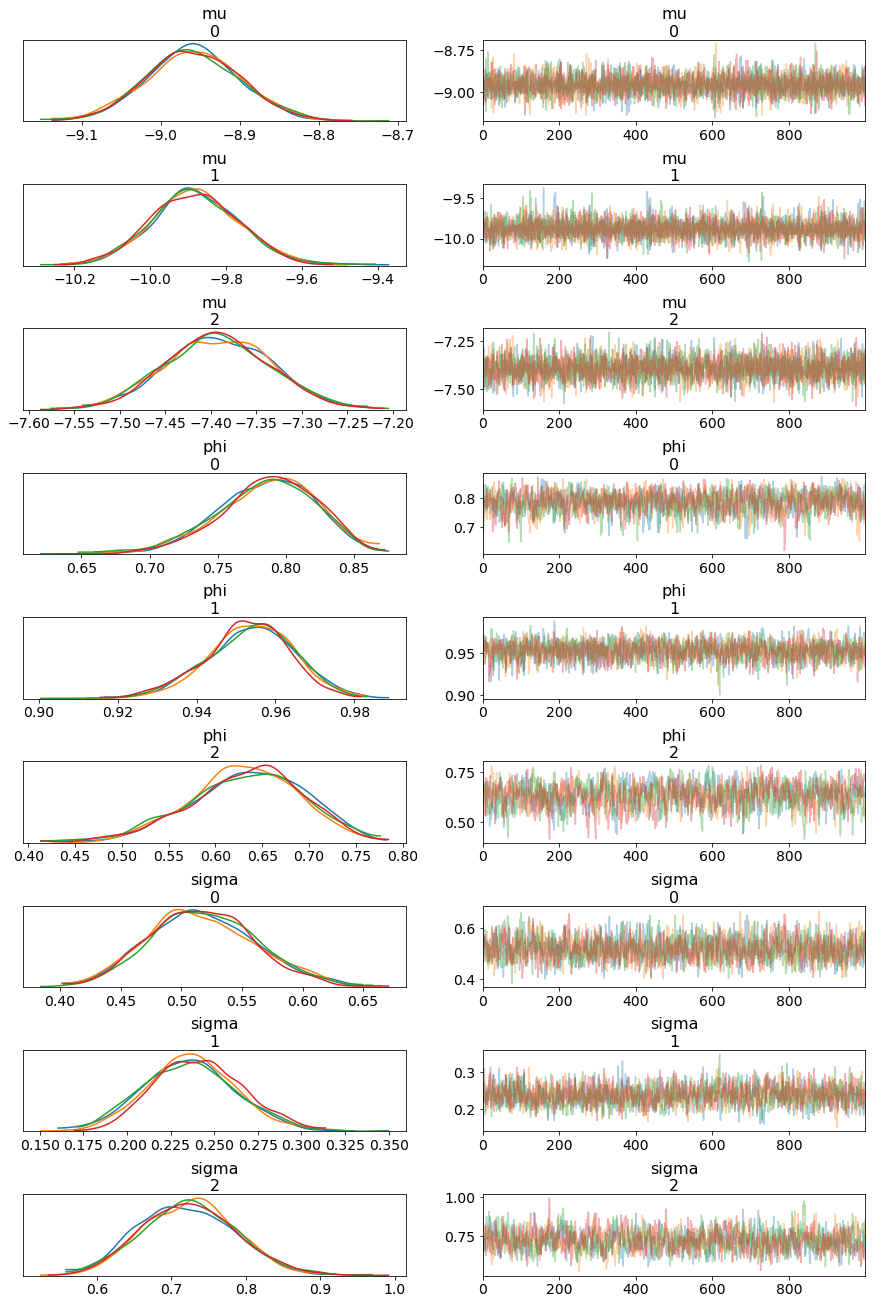

In [8]:
arviz.plot_trace(inf_data, var_names=['mu', 'phi', 'sigma'])